In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Importing Libraries


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import joblib


# Loading and Preprocessing Data

In [43]:
# train.csv 
train_crimes = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
train_crimes.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [44]:
# test.csv
test_crimes = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
test_crimes.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [45]:
# Function to preprocess date columns
def preprocess_dates(df):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format=date_format)
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'], format=date_format)
    df['Year_Reported'] = df['Date_Reported'].dt.year
    df['Month_Reported'] = df['Date_Reported'].dt.month
    df['Day_Reported'] = df['Date_Reported'].dt.day
    df['Day_of_Week_Reported'] = df['Date_Reported'].dt.dayofweek
    df['Hour_Occurred'] = df['Time_Occurred'].apply(lambda x: int(x // 100))
    return df

# Apply date preprocessing
train_crimes = preprocess_dates(train_crimes)
test_crimes = preprocess_dates(test_crimes)

# Handling missing values

In [46]:
# Replace infinite values with NaNs
train_crimes.replace([np.inf, -np.inf], np.nan, inplace=True)
test_crimes.replace([np.inf, -np.inf], np.nan, inplace=True)

# check for NaN values
print(f"Count of NaN values in 'train_csv': {train_crimes.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test_crimes.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 49876 values
Count of NaN values in 'test_csv': 12467 values


In [47]:
# train_csv
train_crimes.isna().sum() # Cross_Street, Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code, Premise_Description, Weapon_Description HAS Nan values

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
Year_Reported                0
Month_Reported               0
Day_Reported                 0
Day_of_Week_Reported         0
Hour_Occurred                0
dtype: int64

In [48]:
# test_csv
test_crimes.isna().sum() # Cross_Street, Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code, Weapon_Description, Premise_Description HAS Nan values

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
Year_Reported               0
Month_Reported              0
Day_Reported                0
Day_of_Week_Reported        0
Hour_Occurred               0
dtype: int64

In [49]:
# Fill NaN values
train_crimes['Cross_Street'] = train_crimes['Cross_Street'].fillna('Unknown')
train_crimes['Modus_Operandi'] = train_crimes['Modus_Operandi'].fillna('Unknown')
train_crimes['Victim_Sex'] = train_crimes['Victim_Sex'].fillna('Unknown')
train_crimes['Victim_Descent'] = train_crimes['Victim_Descent'].fillna('Unknown')
train_crimes['Premise_Description'] = train_crimes['Premise_Description'].fillna('Unknown')
train_crimes['Weapon_Description'] = train_crimes['Weapon_Description'].fillna('Unknown')

test_crimes['Cross_Street'] = test_crimes['Cross_Street'].fillna('Unknown')
test_crimes['Modus_Operandi'] = test_crimes['Modus_Operandi'].fillna('Unknown')
test_crimes['Victim_Sex'] = test_crimes['Victim_Sex'].fillna('Unknown')
test_crimes['Victim_Descent'] = test_crimes['Victim_Descent'].fillna('Unknown')
test_crimes['Premise_Description'] = test_crimes['Premise_Description'].fillna('Unknown')
test_crimes['Weapon_Description'] = test_crimes['Weapon_Description'].fillna('Unknown')

# fill missing numerical values with the median values
train_crimes['Weapon_Used_Code'] = train_crimes['Weapon_Used_Code'].fillna(train_crimes['Weapon_Used_Code'].median())
test_crimes['Weapon_Used_Code'] = test_crimes['Weapon_Used_Code'].fillna(train_crimes['Weapon_Used_Code'].median())

In [50]:
# verify for NaN values
print(f"Count of NaN values in 'train_csv': {train_crimes.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test_crimes.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 0 values
Count of NaN values in 'test_csv': 0 values


# Exploratory Data Analysis

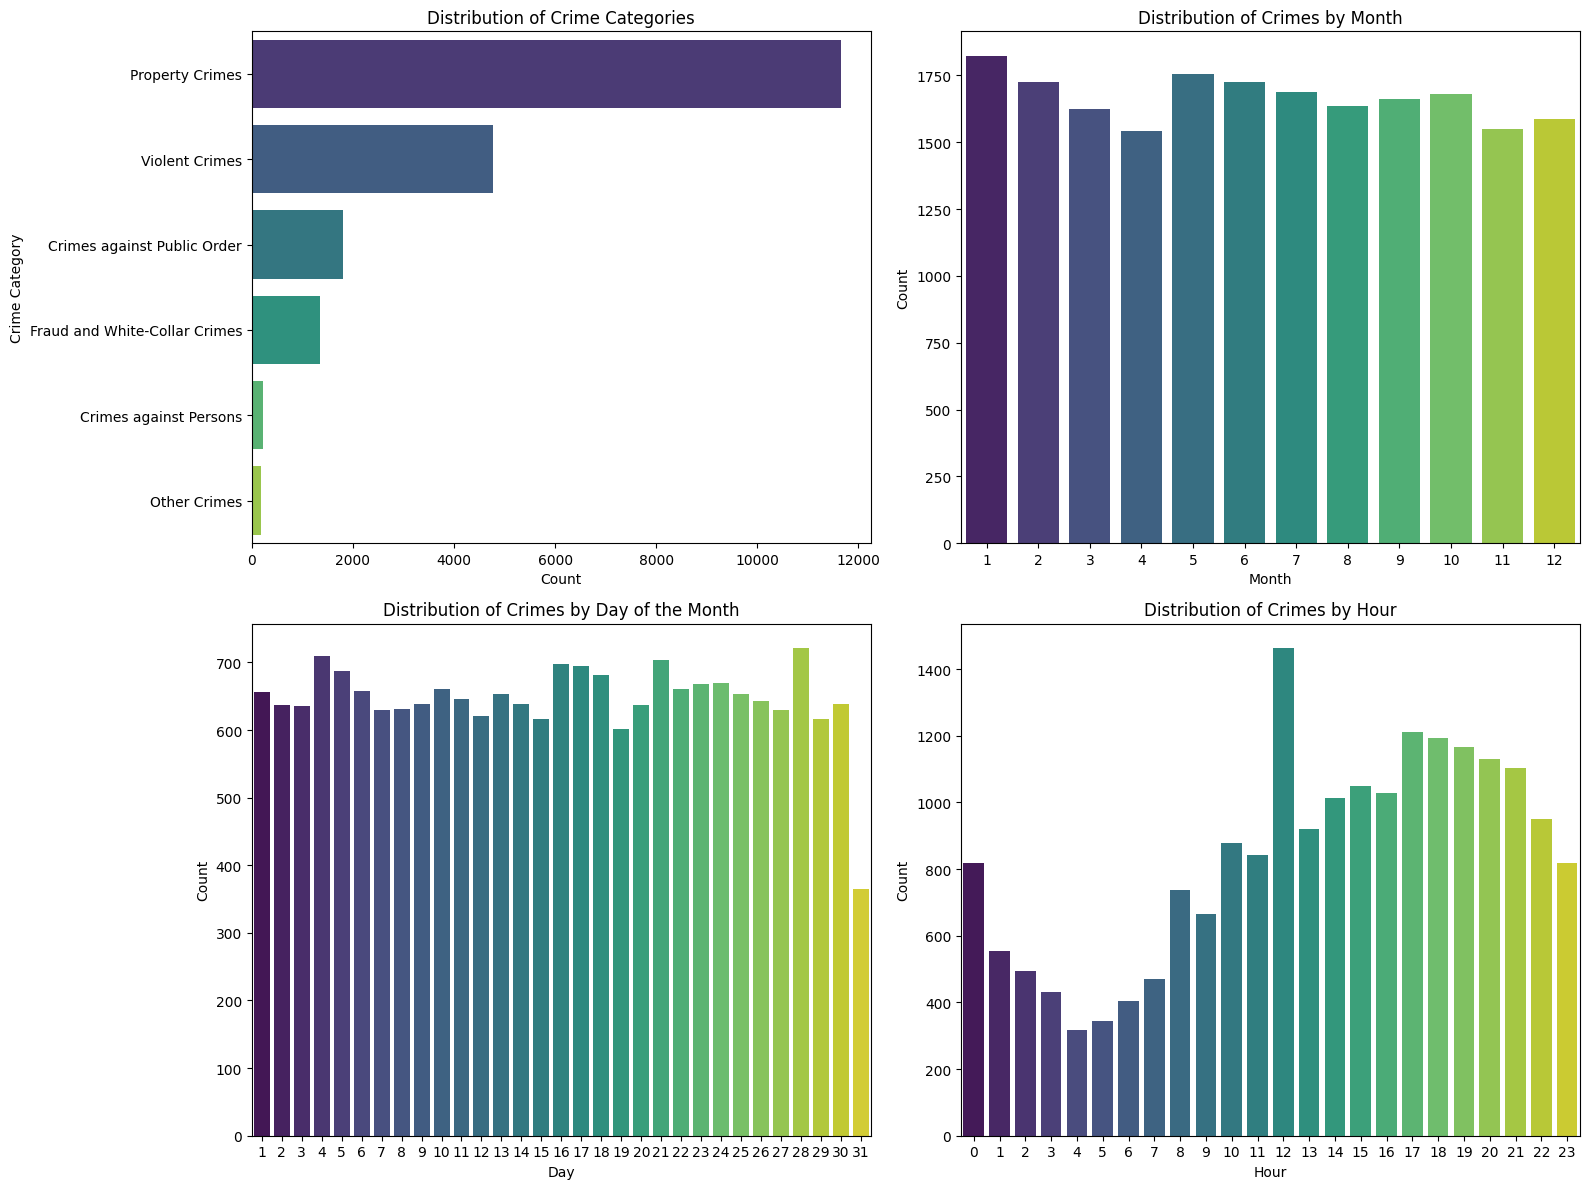

In [51]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(16, 12))

# Distribution of crime categories
plt.subplot(2, 2, 1)
sns.countplot(y='Crime_Category', data=train_crimes, order=train_crimes['Crime_Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Crime Categories')
plt.xlabel('Count')
plt.ylabel('Crime Category')

# Distribution of crimes by month
plt.subplot(2, 2, 2)
sns.countplot(x='Month_Reported', data=train_crimes, palette='viridis')
plt.title('Distribution of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Distribution of crimes by day of the month
plt.subplot(2, 2, 3)
sns.countplot(x='Day_Reported', data=train_crimes, palette='viridis')
plt.title('Distribution of Crimes by Day of the Month')
plt.xlabel('Day')
plt.ylabel('Count')

# Distribution of crimes by hour
plt.subplot(2, 2, 4)
sns.countplot(x='Hour_Occurred', data=train_crimes, palette='viridis')
plt.title('Distribution of Crimes by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

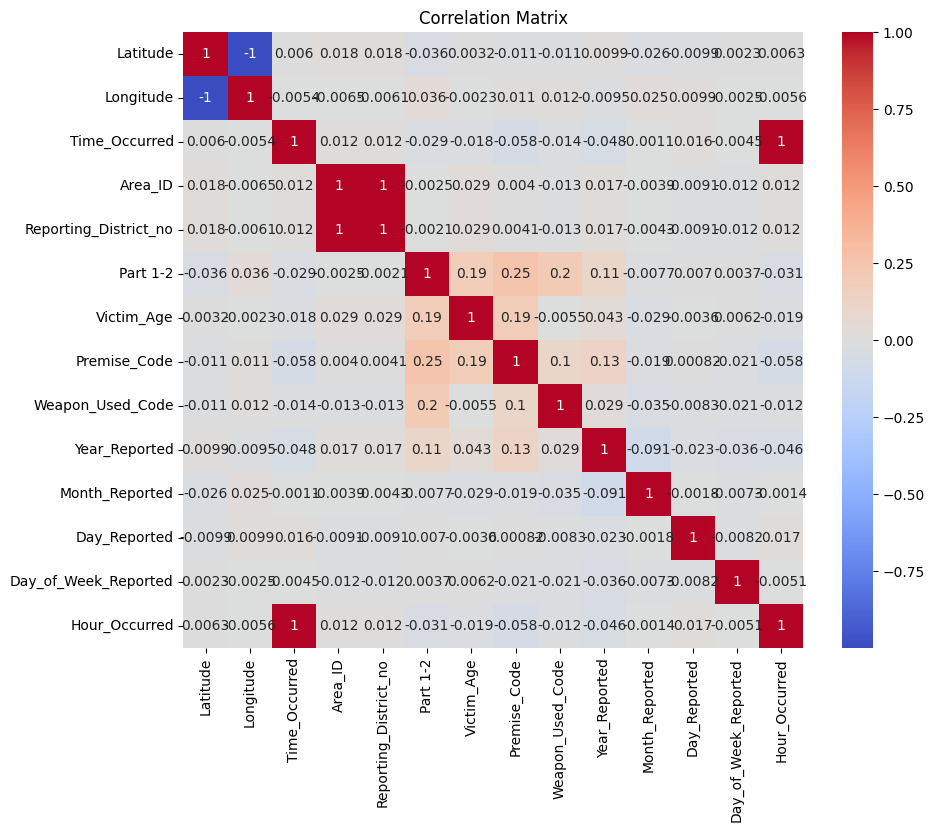

<Figure size 1200x800 with 0 Axes>

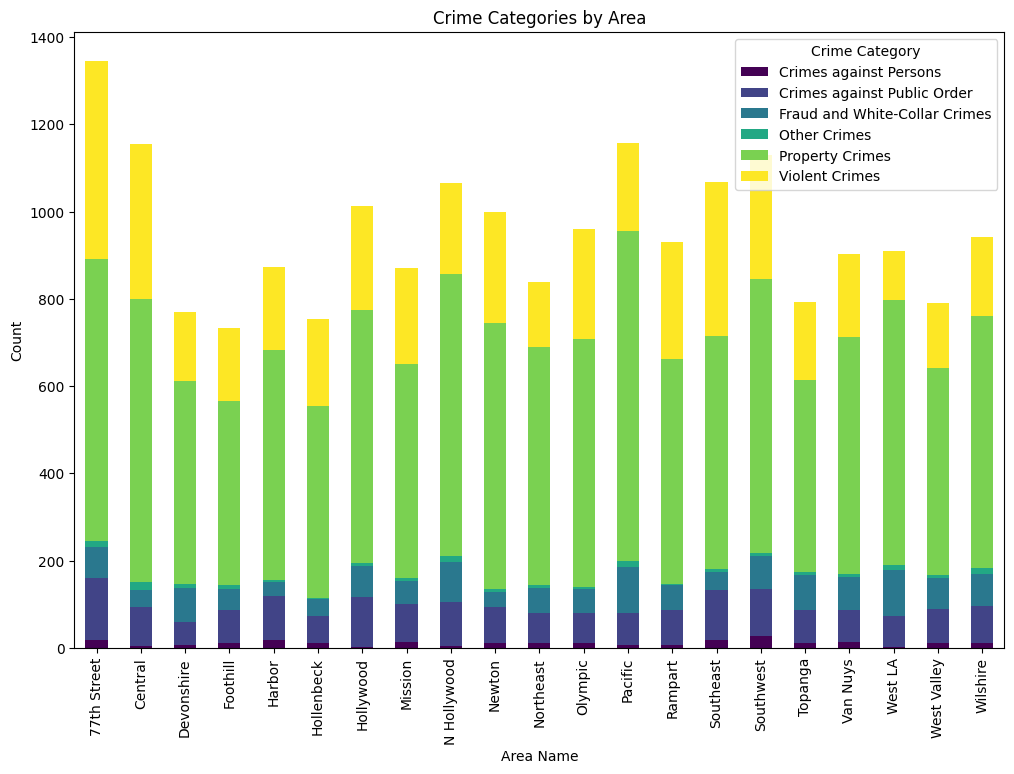

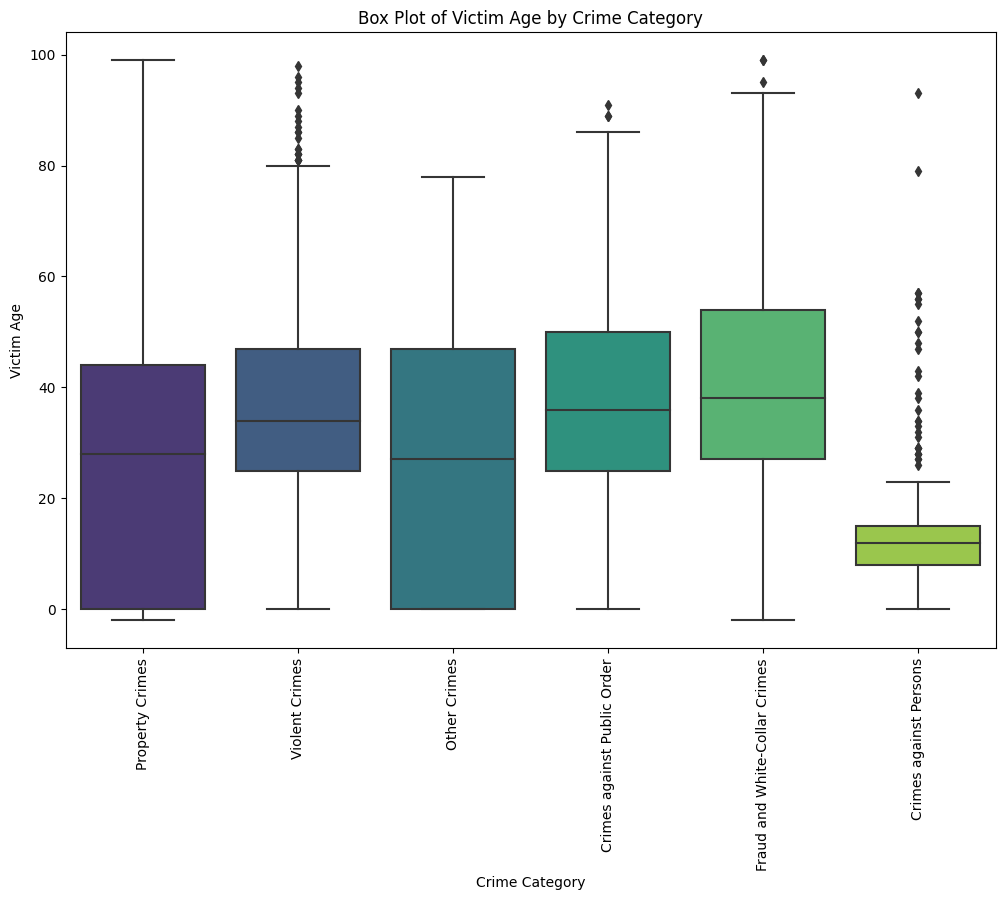

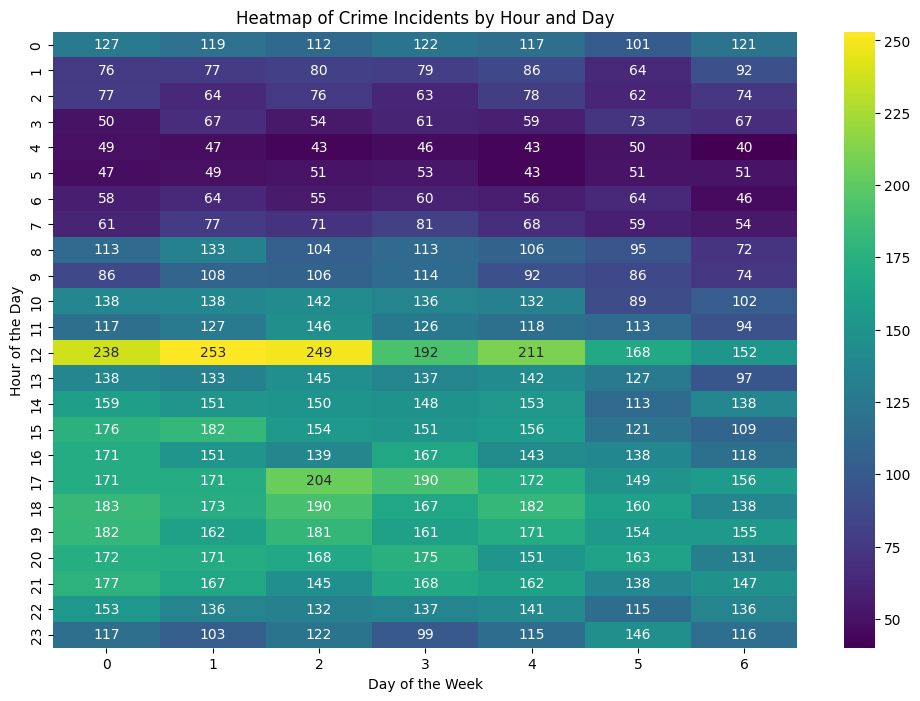

In [52]:
# Select only numeric columns for correlation matrix
numeric_cols = train_crimes.select_dtypes(include=[np.number]).columns

# 1. Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_crimes[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2. Bar Plot of Crime Categories by Area
plt.figure(figsize=(12, 8))
crime_by_area = train_crimes.groupby('Area_Name')['Crime_Category'].value_counts().unstack().fillna(0)
crime_by_area.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Crime Categories by Area')
plt.xlabel('Area Name')
plt.ylabel('Count')
plt.legend(title='Crime Category')
plt.show()

# 3. Box Plot of Victim Age by Crime Category
plt.figure(figsize=(12, 8))
sns.boxplot(x='Crime_Category', y='Victim_Age', data=train_crimes, palette='viridis')
plt.title('Box Plot of Victim Age by Crime Category')
plt.xlabel('Crime Category')
plt.ylabel('Victim Age')
plt.xticks(rotation=90)
plt.show()

# 4. Heatmap of Crime Incidents by Hour and Day
hour_day_matrix = train_crimes.pivot_table(index='Hour_Occurred', columns='Day_of_Week_Reported', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Crime Incidents by Hour and Day')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value='Unknown'):
        self.fill_value = fill_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna(self.fill_value)


In [54]:
# Fill missing values in numerical columns
X_train[numerical_columns] = X_train[numerical_columns].fillna(X_train[numerical_columns].median())
X_test[numerical_columns] = X_test[numerical_columns].fillna(X_test[numerical_columns].median())

In [55]:
# Define preprocessing for numeric columns (imputation + scaling) and categorical columns (imputation + encoding)
categorical_columns = ['Location', 'Cross_Street', 'Area_Name', 'Modus_Operandi', 
                       'Victim_Sex', 'Victim_Descent', 'Premise_Description', 
                       'Weapon_Description', 'Status', 'Status_Description']
numerical_columns = ['Time_Occurred', 'Victim_Age', 'Weapon_Used_Code']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', CustomCategoricalImputer(fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [56]:
# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    labelE = LabelEncoder()
    train_crimes[col] = labelE.fit_transform(train_crimes[col])
    
    # handle unseen labels in test data
    test_crimes[col] = test_crimes[col].map(lambda s: '<unknown>' if s not in labelE.classes_ else s)
    labelE.classes_ = np.append(labelE.classes_, '<unknown>')
    test_crimes[col] = labelE.transform(test_crimes[col])
    
    # store the label encoder
    label_encoders[col] = labelE

In [57]:
# Prepare target variable
y = train_crimes['Crime_Category']
X = train_crimes.drop(columns=['Date_Reported', 'Date_Occurred', 'Crime_Category'])

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [58]:
# encode the target variable 'Crime_Category'
labelE_crime_category = LabelEncoder()
train_crimes['Crime_Category'] = labelE_crime_category.fit_transform(train_crimes['Crime_Category'])

In [59]:
# Scale numerical features
scaler = StandardScaler()
numerical_columns = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID', 
                     'Reporting_District_no', 'Part 1-2', 'Victim_Age', 
                     'Premise_Code', 'Weapon_Used_Code']

train_crimes[numerical_columns] = scaler.fit_transform(train_crimes[numerical_columns])
test_crimes[numerical_columns] = scaler.transform(test_crimes[numerical_columns])

In [60]:
X_train = train_crimes.drop(columns=['Crime_Category', 'Date_Reported', 'Date_Occurred'])
y_train = train_crimes['Crime_Category']

# prepare test data (assuming
X_test = test_crimes.drop(columns=['Date_Reported', 'Date_Occurred'])

# split the training data further into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train_split.shape, X_val_split.shape, y_train_split.shape, y_val_split.shape)


(16000, 24) (4000, 24) (16000,) (4000,)


In [61]:
train_crimes['Crime_Category'].unique() # labels

array([4, 5, 3, 1, 2, 0])

# Hyperparameter tuning

In [63]:
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Hyperparameter grids
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.2],
        'classifier__max_depth': [3, 5]
    },
    'XGBoost': {
        'classifier__n_estimators': [90, 100],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [6, 7],
        'classifier__min_child_weight': [4, 5],
        'classifier__subsample': [0.9, 1.0],
        'classifier__colsample_bytree': [0.5, 0.6]
    },
    'LightGBM': {
        'classifier__num_leaves': [31, 40],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.2],
        'classifier__min_child_weight': [1, 3],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
}

In [64]:
# Perform hyperparameter tuning
best_models = {}
for model_name in models.keys():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', models[model_name])])
    
    grid_search = RandomizedSearchCV(pipeline, param_grids[model_name], n_iter=8, cv=3, n_jobs=-1, verbose=1, random_state=42)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 13333, number of used features: 170
[LightGBM] [Info] Start training from score -4.487362
[LightGBM] [Info] Start training from score -2.402933
[LightGBM] [Info] Start training from score -2.692275
[LightGBM] [Info] Start training from score -4.718874
[LightGBM] [Info] Start training from score -0.539072
[LightGBM] [Info] Start training from score -1.433990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

# Pipeline

# Training and evaluating models

In [65]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    target_names = [str(class_) for class_ in le.classes_]
    report = classification_report(y_val, y_val_pred, target_names=target_names, zero_division=0)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    return accuracy, report, conf_matrix

# Evaluate models and keep track of the best one
best_model_name = None
best_model = None
best_accuracy = 0

# Evaluate all models
for name, model in best_models.items():
    accuracy, report, conf_matrix = evaluate_model(model, X_train, y_train, X_val, y_val)
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n{report}")
    print(f"{name} Confusion Matrix:\n{conf_matrix}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = model

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")


RandomForest Accuracy: 0.6855
RandomForest Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       1.00      0.05      0.09       362
Fraud and White-Collar Crimes       0.00      0.00      0.00       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.66      0.99      0.79      2333
               Violent Crimes       0.82      0.45      0.58       953

                     accuracy                           0.69      4000
                    macro avg       0.41      0.25      0.24      4000
                 weighted avg       0.67      0.69      0.61      4000

RandomForest Confusion Matrix:
[[   0    0    0    0   28   17]
 [   0   18    0    0  304   40]
 [   0    0    0    0  271    0]
 [   0    0    0    0   36    0]
 [   0    0    0    0 2299   34]
 [   0    0    0    0  52

# Saving best model

In [66]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')

# Assuming label encoder 'le' and test data 'X_test' and 'test_crimes' are already defined
# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test)


# Decode the predictions
y_test_pred_decoded = labelE_crime_category.inverse_transform(y_test_pred)

# Create the submission file
test_crimes.reset_index(drop=True, inplace=True)
submission = pd.DataFrame({'ID': test_crimes.index + 1, 'Crime_Category': y_test_pred_decoded})
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

   ID               Crime_Category
0   1               Violent Crimes
1   2              Property Crimes
2   3              Property Crimes
3   4              Property Crimes
4   5  Crimes against Public Order


# Insights and findings
Most "Fraud and White Collar Crimes" and "Crimes Against Persons " occur in the first week of the month.

"Property Crimes" and "Violent Crimes" are evenly distributed through the month.

Most " Other Crimes" occur in the third week of the month.

Maximum crime occurs in the area whose name is 77th Street

The most common used weapon is 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)'

Maximum crime occurs on the first day of the month and on the 4th day of the week and at noon.

The most crimes are committed against victims of descent 'H'

In case of most of the crimes the victim age is unknown or there was no victim present.

Most crime occurs in January

**Best model is GradientBoosting with an accuracy of 0.8698**